### 1. Load Regular data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ds0 = np.load(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\all_radars.npy')

In [ ]:
print(ds0.shape)
print(ds0.min(), ds0.max())

### 1.1 Normalize data to [0,1]
- set max dbz to 75

In [ ]:
max_dbz = 75
ds = ds0 / max_dbz

print(ds.shape)
print(ds.min(), ds.max())

### 2 Rotating data to get more examples

- flip x
- flip y
- rotate 90 Degrees
- rotate 180 Degrees
- rotate 270 Degrees

### 2.1 Flip and Rotate data

In [ ]:
# Flipping
flipped_x = np.flip(ds, axis=2)  # Vertical flip
flipped_y = np.flip(ds, axis=1)  # Horizontal flip

In [ ]:
flipped_x.max()

In [ ]:
# Rotations
rotated_90 = np.rot90(ds, k=1, axes=(1, 2))  # 90° rotation
rotated_180 = np.rot90(ds, k=2, axes=(1, 2))  # 180° rotation
rotated_270 = np.rot90(ds, k=3, axes=(1, 2))  # 270° rotation


#### visual check the rotated and flipped data

In [ ]:
#Original
plt.imshow(ds[30],cmap='jet')
plt.show()

In [ ]:
#Flip x
plt.imshow(flipped_x[30],cmap='jet')
plt.show()

In [ ]:
#Flip y
plt.imshow(flipped_y[30],cmap='jet')
plt.show()

In [ ]:
#rotat 90
plt.imshow(rotated_90[30],cmap='jet')
plt.show()

In [ ]:
#rotat 180
plt.imshow(rotated_180[30],cmap='jet')
plt.show()

In [ ]:
#rotat 270
plt.imshow(rotated_270[30],cmap='jet')
plt.show()

### 2.2 Save all data into one big npz file

In [ ]:
np.savez(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\all_radars_rotated_flipped_normalized.npz', original=ds, flipped_x = flipped_x, flipped_y=flipped_y,rotated_90= rotated_90, rotated_180=rotated_180, rotated_270=rotated_270)

### 3. Customize Dataset Class

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import math

### 3.1 Customized for multiple datasets
- training data must be in sequencial, there will be gap between two datasets
- in init function, will **load different datasets** into different element in **ds_list array**
- **ds_pos list** holds the **max number of training datasets** this dataset can generated, **must be integer**, use floor if result is decimal
- when **getitem** is called, first need to **scan all lists** and make sure to **skip data if the data is combined with 2 different datasets** 

In [2]:
class RadarDataset(Dataset):
    def __init__(self, file_path,in_len, out_len, steps, transform=None):
        self.in_len = in_len          # length of input frames
        self.out_len = out_len        # length of output frames
        self.total = in_len+out_len   # total length of both frames, this more like a moving window
        self.steps = steps            # how many frames to skip on each window moving
        
        #all tile images
        ds_list=[]
        #max number of sets depend on output length
        ds_pos=[]
        ds_all = np.load(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\all_radars_rotated_flipped_normalized.npz')
        print('all data loaded')

        ds = ds_all['original']
        print(ds.shape)
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['flipped_x']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)

        ds = ds_all['flipped_y']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['rotated_90']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['rotated_180']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)
        
        ds = ds_all['rotated_270']
        ds_list.append(ds)
        ds_pos.append((len(ds)-self.total) // self.steps + 1)

        
        self.ds_list = ds_list
        self.ds_pos = ds_pos
        print('max number of sets', ds_pos)
                
        self.transform = transform
        

    def __len__(self):
        return sum(self.ds_pos)
    
    def __getitem__(self, i):
        num_list=0
        num_in_list = 0
        cumulative_sum = 0
        for k, length in enumerate(self.ds_pos):
            cumulative_sum += length
            if i < cumulative_sum:
                num_list,num_in_list = k, i - (cumulative_sum - length)
                break
        #print(num_list,num_in_list)
        
        ds_element = self.ds_list[num_list]
        #print(ds_element.shape)
        data_seg =  ds_element[(num_in_list)*self.steps:(num_in_list)*self.steps+self.total,:,:]
        
        data_ins = data_seg[:self.in_len,:,:]
        data_outs = data_seg[self.in_len:, :, :]
        
        #Convert npmpy data to tensor
        t_inputs = torch.tensor(data_ins,dtype=torch.float32)
        t_targets = torch.tensor(data_outs,dtype=torch.float32)
        
        if self.transform:
            t_inputs = self.transform(t_inputs)
            t_targets = self.transform(t_targets)

        #t_inputs = t_inputs.permute(1, 0, 2, 3) #new shape should be (2,8,512,512)
        #t_targets = t_targets.permute(1, 0, 2, 3) #new shape should be (1,3,512,512)
        return t_inputs,t_targets


#### this is a test, only load small data in one zone

In [3]:
# Define the transform
tile_size = 128
transform = transforms.Compose([
    transforms.Resize((tile_size, tile_size))
])

### 3.2 Generate Training Dataset for Testing

In [4]:
train = RadarDataset(file_path = '', 
                  in_len = 12, 
                  out_len = 6,
                  steps = 6,
                  transform=None
                 )

all data loaded
(297, 540, 540)
max number of sets [47, 47, 47, 47, 47, 47]


In [5]:
ins,outs = train.__getitem__(0)

In [6]:
ins.shape,outs.shape

(torch.Size([12, 540, 540]), torch.Size([6, 540, 540]))

In [7]:
train.__len__()

282

In [8]:
ins.max()

tensor(0.2987)

### 3.3 Visual check the data

#### Sequencial 18 frames (12 input + 6 Targets) 

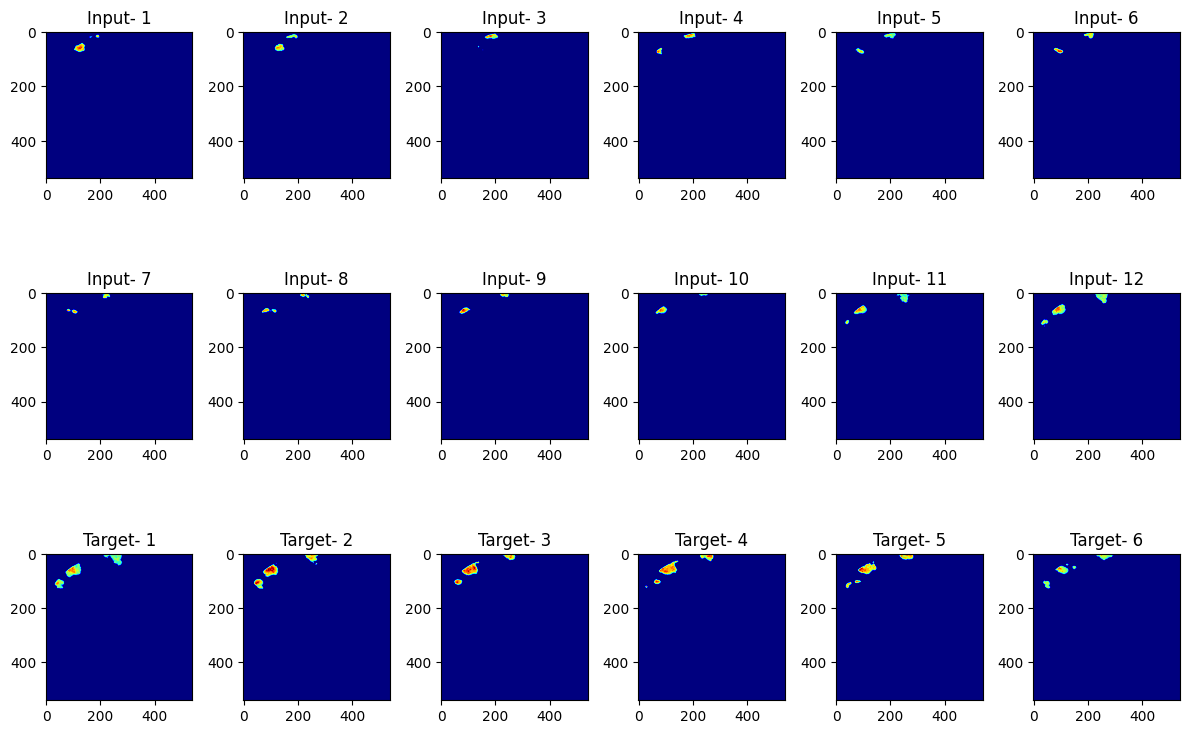

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 6, figsize=(12,8))

for j in range(6):
    axes[0,j].imshow(ins[j,:,:],cmap='jet')
    axes[0,j].set_title(f'Input- {j+1}')
for j in range(6):
    axes[1,j].imshow(ins[j+6,:,:],cmap='jet')
    axes[1,j].set_title(f'Input- {j+7}')

for j in range(6):
    axes[2,j].imshow(outs[j,:,:],cmap='jet')
    axes[2,j].set_title(f'Target- {j+1}')

plt.tight_layout()
plt.show()

#### Get 100th elements

In [10]:
ins,outs = train.__getitem__(100)

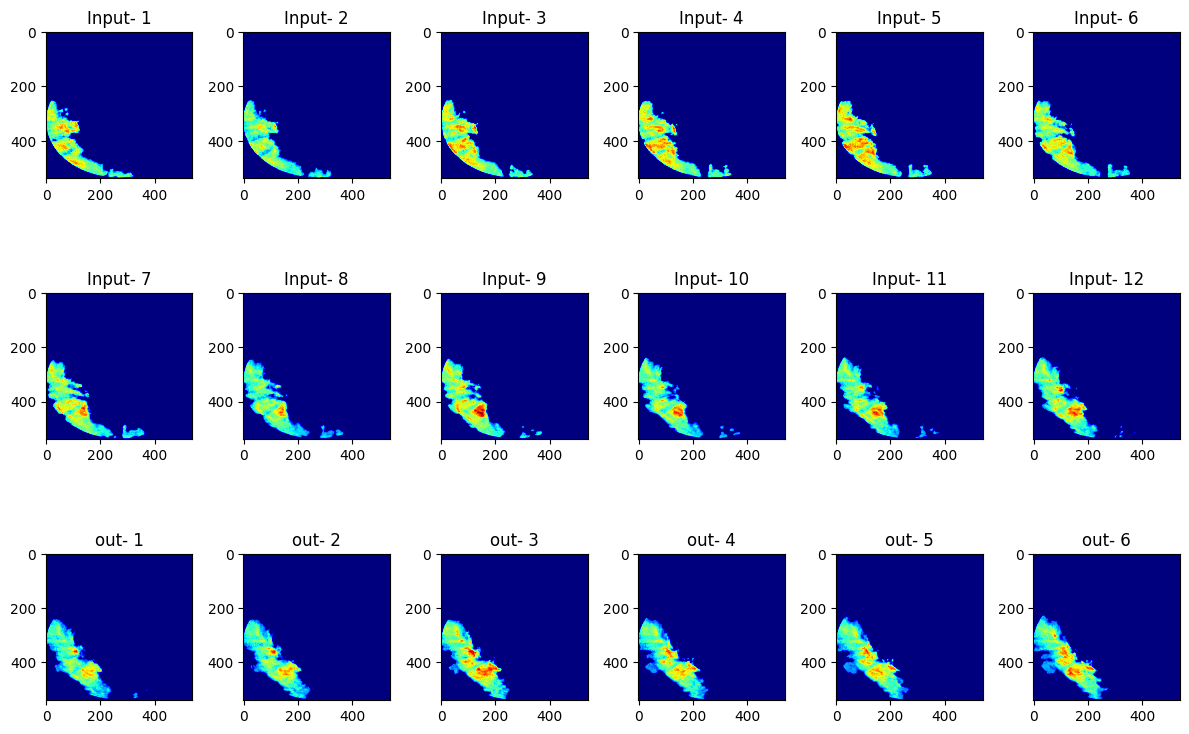

In [11]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure and an array of subplots
fig, axes = plt.subplots(3, 6, figsize=(12,8))

for j in range(6):
    axes[0,j].imshow(ins[j,:,:],cmap='jet')
    axes[0,j].set_title(f'Input- {j+1}')
for j in range(6):
    axes[1,j].imshow(ins[j+6,:,:],cmap='jet')
    axes[1,j].set_title(f'Input- {j+7}')

for j in range(6):
    axes[2,j].imshow(outs[j,:,:],cmap='jet')
    axes[2,j].set_title(f'out- {j+1}')

plt.tight_layout()
plt.show()

### 4. Train Loader

In [12]:
bs = 3
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=bs, shuffle=True)

### 5. Setup UNet Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3):
        super(ConvBlock, self).__init__()
        # kernel_size=3
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [15]:
class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels,output_frames, features=[64, 128, 256, 512]):
        super(UNet2D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        #self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.output_frames = output_frames

        # Encoder
        for feature in features:
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature
                  
        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(ConvBlock(feature*2, feature))

        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        #self.time_conv = nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(12, 1, 1), stride=(1, 1, 1))

    def forward(self, x):
        skip_connections = []
                    
        #Encoder
        for encoder in self.encoder:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        
        # Decoder
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='nearest')
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)

        return self.final_conv(x)


### 6. Train

In [16]:
import torch
import torchvision
from torch import optim
#from tqdm import tqdm
from tqdm.notebook import tqdm
import torchvision.utils as torchutils

In [17]:
epochs=10
lr=1e-4
bs=3
best_loss = float('inf')

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model initialization
in_channels = 12  # band08 and band13
out_channels = 6  # Only band13 for output
output_frames = 6

# Initialize the model
model = UNet2D(in_channels=12, out_channels=6,output_frames=6)
model.to(device)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=bs, shuffle=True)

Using device: cuda


In [18]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Define the scheduler
# mode='min' ensures the learning rate decreases when the loss does not decrease
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.05, verbose=True)

In [19]:
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def custom_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce * 0.5 + dice * 0.5

In [21]:
num_epochs = 51
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
        
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
        optimizer.zero_grad()
        outputs = model(batch_x)
        #loss = criterion(outputs, batch_y)
        loss = custom_loss(outputs, batch_y)
        
        # save model
        if loss < best_loss:
            print('=== best loss: ',loss)
            best_loss = loss
            torch.save(model.state_dict(), r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\training_log\unet_2D_radar_Dataset_best.pth')
            
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
    # Step the scheduler based on training loss
    scheduler.step(train_loss)  # Reduce LR if train_loss hasn't improved for 'patience' epochs
    # Print learning rate and losses
    current_lr = optimizer.param_groups[0]['lr']
    print('current lr: ',current_lr)
    # Log metrics to wandb
    #wandb.log({"epoch": epoch+1, "train_loss": avg_loss})
    if epoch%5==0:
        np.save(f"D:/Tommy/++AI/++datasets/jv_radar/batch_process_img/training_log/target_2d_{epoch}.npy",batch_x.cpu().numpy())
        np.save(f"D:/Tommy/++AI/++datasets/jv_radar/batch_process_img/training_log/predict_2d_{epoch}.npy",outputs.detach().cpu().numpy())

=== best loss:  tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1/51, Train Loss: 0.5185
current lr:  0.0001
=== best loss:  tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss:  tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)
=== best loss

### 5. Check epoch results during training 

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [33]:
t_ds = np.load(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\training_log\target_2d_50.npy')
p_ds = np.load(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\training_log\predict_2d_50.npy')
t_ds.shape, p_ds.shape

((3, 12, 540, 540), (3, 6, 540, 540))

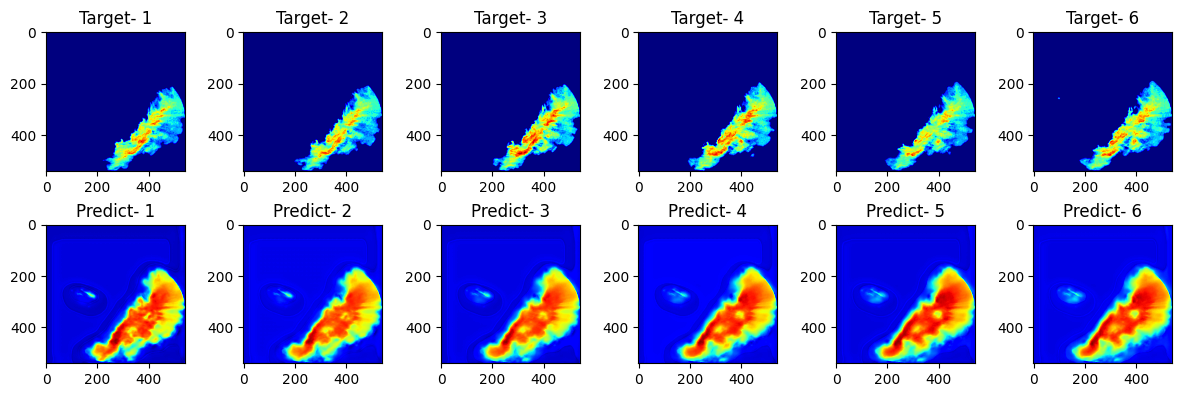

In [34]:
# Create a figure and an array of subplots
fig, axes = plt.subplots(2, 6, figsize=(12,4))

for j in range(6):
    axes[0,j].imshow(t_ds[0,j,:,:],cmap='jet')
    axes[0,j].set_title(f'Target- {j+1}')

for j in range(6):
    axes[1,j].imshow(p_ds[0,j,:,:],cmap='jet')
    axes[1,j].set_title(f'Predict- {j+1}')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

#### Epoch 200 with dynamic LR on full images
- Epoch 0
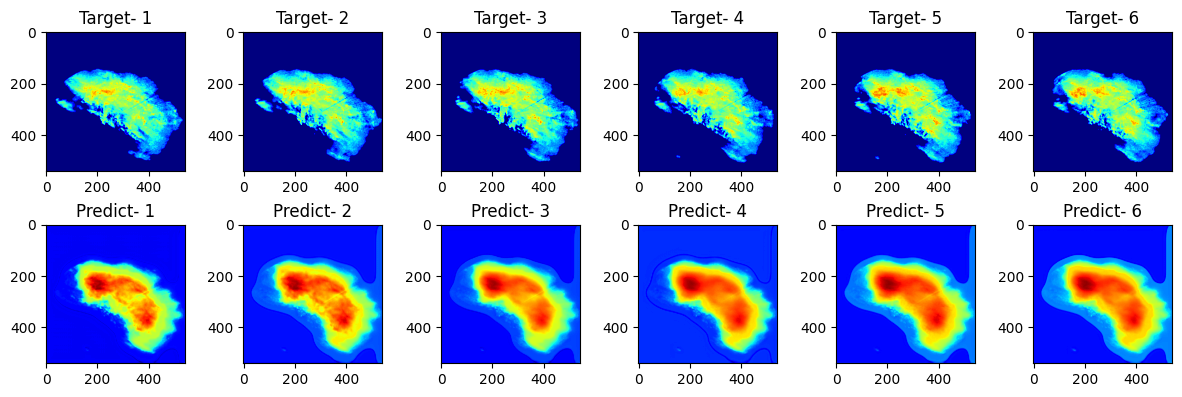

- epoch 10
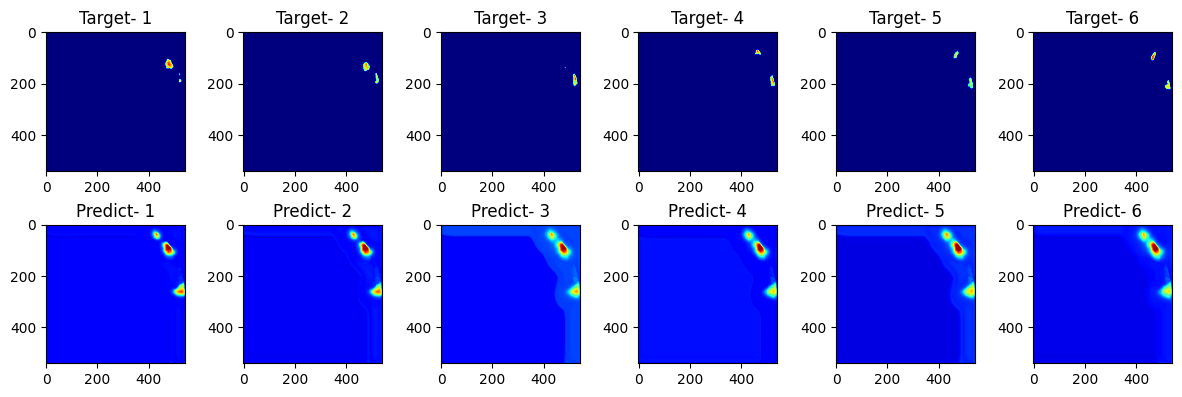

- epoch 20
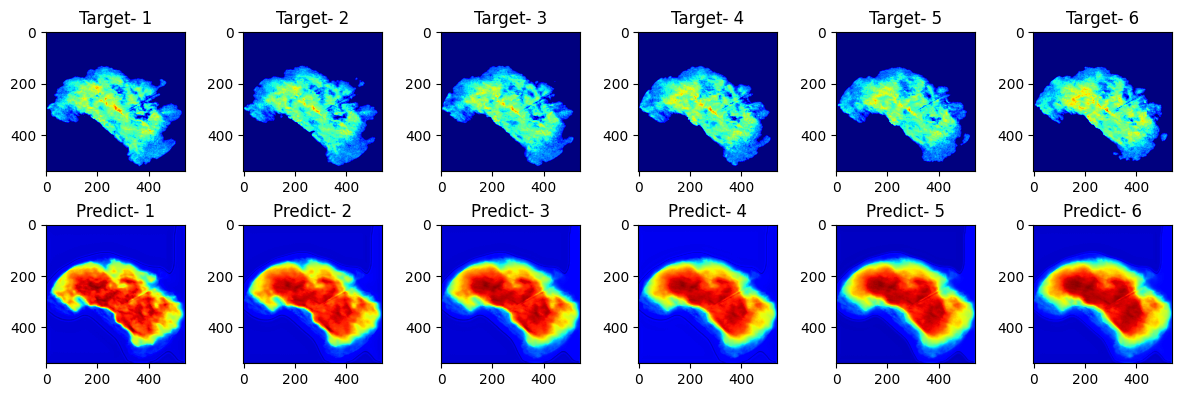

- epoch 30
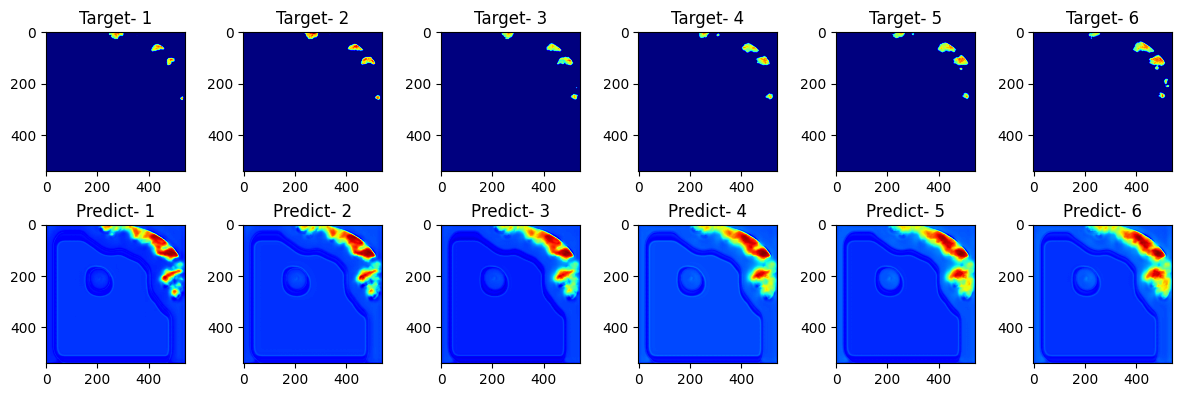

- epoch 40
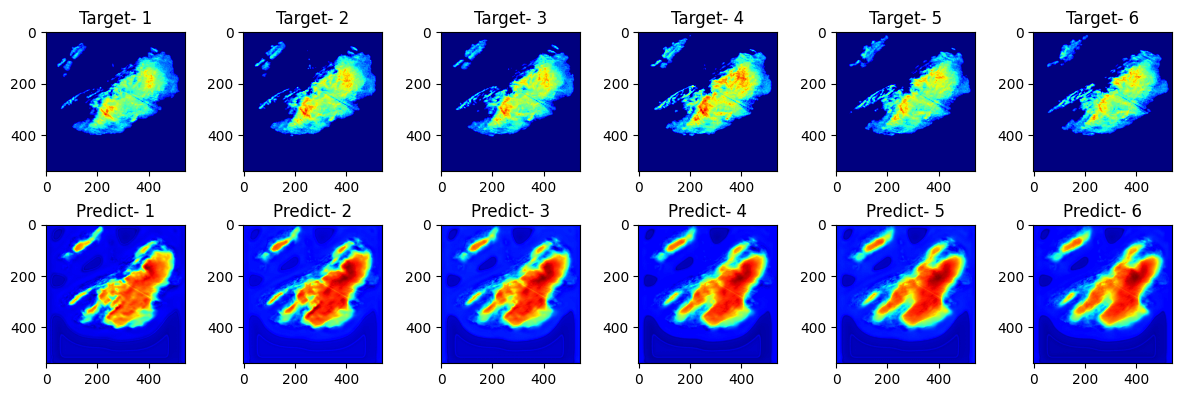

- epoch 50
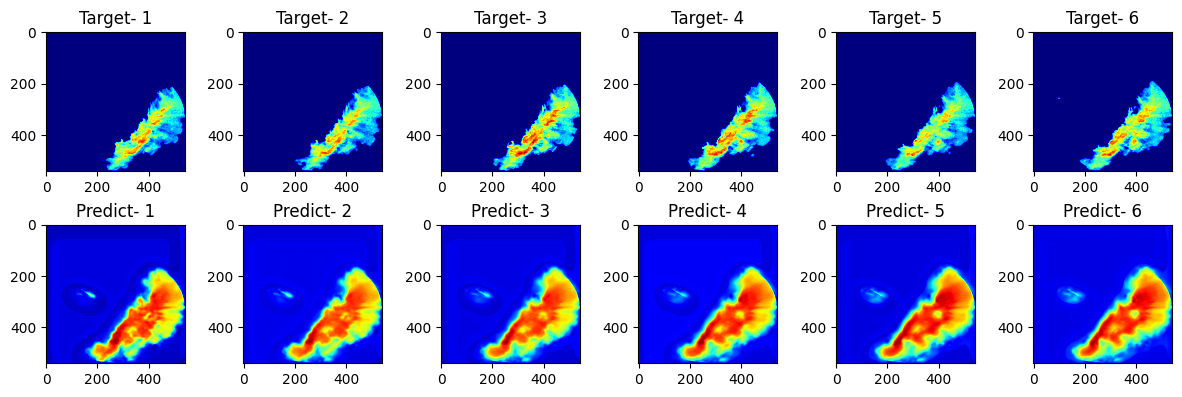



### 6. Test Trained Model

#### 6.1 Load Data

In [35]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model initialization
in_channels = 12  # band08 and band13
out_channels = 6  # Only band13 for output
output_frames = 6

# Initialize the model
model = UNet2D(in_channels=12, out_channels=6,output_frames=6)
model.to(device)

model_save_path = r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\training_log\unet_2D_radar_Dataset_best.pth'
model.load_state_dict(torch.load(model_save_path))

Using device: cuda


<All keys matched successfully>

In [36]:
test_ds = np.load(r'D:\Tommy\++AI\++datasets\jv_radar\batch_process_img\all_radars.npy')

In [42]:
test_ds.shape, test_ds.max()

((297, 540, 540), 57.4)

#### 6.2 Create one test input and target dataset

In [38]:
#test input
test_data = test_ds[100:112]/75 #normalize
# targets should be
target_data = test_ds[112:118]/75 #normalize

In [40]:
test_data.shape, target_data.shape

((12, 540, 540), (6, 540, 540))

In [41]:
test_data.max()

0.6960000000000001

#### 6.3 convert from numpy to tensor and load to GPU

In [45]:
#convert np array to tensor
t_image = torch.tensor(test_data, dtype=torch.float32)
#load data to CUDA GPU memory
input_image = t_image.to(device)
test_image = input_image[np.newaxis,:,:,:]
test_image.shape

torch.Size([1, 12, 540, 540])

#### 6.4 Run trained model to generate predicted output

In [46]:
model.eval()
# Predict
with torch.no_grad():
    output = model(test_image)
    # Apply sigmoid to ensure output is in the [0, 1] range
    output = torch.sigmoid(output)
output.shape

torch.Size([1, 6, 540, 540])

#### 6.5 move output data from GPU to CPU for future usage

In [47]:
output_image = output.detach().cpu().numpy()
output_image.shape

(1, 6, 540, 540)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

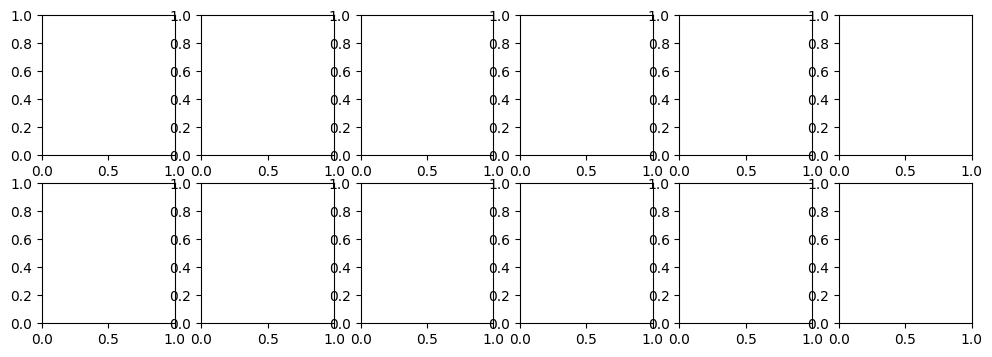

In [48]:
# Create a figure and an array of subplots
fig, axes = plt.subplots(2, 6, figsize=(12,4))

for j in range(6):
    axes[0,j].imshow(target_data[0,j,:,:],cmap='jet')
    axes[0,j].set_title(f'Target- {j+1}')

for j in range(6):
    axes[1,j].imshow(output_image[0,j,:,:],cmap='jet')
    axes[1,j].set_title(f'Predict- {j+1}')
# Adjust spacing between subplots
plt.tight_layout()
plt.show()